In [3]:
from datetime import date
import os

from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [4]:
data_path = r'../data/amazon-data-phase-1-download/'
filepaths = [data_path+f for f in os.listdir(data_path) if f.endswith('.csv')]
print('%s total files to read' % len(filepaths))

2767 total files to read


In [5]:
filepaths[:3]

['../data/amazon-data-phase-1-download/R_hrzkhELGx5jezT7_R_3I9Pu8iauEcOx9A.csv',
 '../data/amazon-data-phase-1-download/R_c2JhEelp5x2LnDO_R_7UtikIBqeQHvnyN.csv',
 '../data/amazon-data-phase-1-download/R_P6kp2IRxc0vVrqu_R_1Nnv2IYQFpUwHrr.csv']

In [6]:
# expected based on other notebook about behavioral
N = 3319
share_rate = 0.817
expected = share_rate * N
print('expected: %s'%expected)

expected: 2711.623


We have more files than those submitted by Prolific participants. May need to do some data cleaning

## Set up

```
categories: dictionary

category_frequencies_df: time series of number of purchases
category_price_median_df: time series of median price for each month
category_price_90p_df: time series of 90% highest price each month
category_price_10p_df: time series of 10% highest price each month
```

Notes:
- purchase price in the CSV is per unit, not the total. So even when quantity > 1, it indicates price for quantity=1

Questions:
- is median best?

In [7]:
"""
categories = {category_name: {'yyyyy-mm': [price for price of each purchase], for each year-month} for each category}
"""

def get_yyyy_mm_list():
    """
    Returns list of 'yyyy-mm' for 2018-01 through 2022-12
    """
    years = ['2018','2019','2020','2021','2022']
    months = list(range(1,13))
    yyyy_mm_list = []
    for year in years:
        for month in months:
            yyyy_mm_list += [year+'-'+'{0:0>2}'.format(month)]
    return yyyy_mm_list

yyyy_mm_list = get_yyyy_mm_list()

def get_category_dict():
    return {yyyy_mm:[] for yyyy_mm in yyyy_mm_list}

In [8]:
categories = dict()
# files_read = 0
files_used = 0
total_purchases = 0

for i, f in enumerate(filepaths):
    if i%500 == 0:
        print('%s: reading file %s - %s files used; %s total purchases' % 
              (pd.Timestamp.now(), i, files_used, total_purchases))
    df = pd.read_csv(f, parse_dates=['Order Date'])
    # Only use data with purchses that begin in 2018 and end in 2022
    if (df['Order Date'].min() > pd.Timestamp('2018-12-31')) | (df['Order Date'].max() < pd.Timestamp('2022-01-01')):
        continue
    files_used += 1
    for index, row in df.iterrows():
        if (row['Order Date'] < pd.Timestamp('2018-01-01')) | (row['Order Date'] > pd.Timestamp('2022-12-31')):
            continue
        # skip rows where purchase price is 0 or undefined (NaN)
        if row.isna()['Purchase Price Per Unit'] or ('$' not in row['Purchase Price Per Unit']):
            continue
        yyyy_mm = date.strftime(row['Order Date'], '%Y-%m')
        category = row['Category']
        price = float(row['Purchase Price Per Unit'].strip('$').replace(',',''))
        if price == 0:
            continue
        if category not in categories:
            categories[category] = get_category_dict()
        categories[category][yyyy_mm] += [price]
        
    total_purchases += index

2023-02-09 21:46:51.615794: reading file 0 - 0 files used; 0 total purchases
2023-02-09 21:47:29.777108: reading file 500 - 418 files used; 173896 total purchases
2023-02-09 21:48:09.408445: reading file 1000 - 838 files used; 347623 total purchases
2023-02-09 21:48:47.750710: reading file 1500 - 1271 files used; 512667 total purchases
2023-02-09 21:49:25.618219: reading file 2000 - 1697 files used; 683893 total purchases
2023-02-09 21:50:01.456552: reading file 2500 - 2113 files used; 848316 total purchases


In [9]:
len(categories)

1789

In [10]:
# print(category)
# categories[category]

In [11]:
categories_total_purchases = dict()
for c, values in categories.items():
    p = 0
    for yyyy_mm, purchases in values.items():
        p += len(purchases)
    categories_total_purchases[c] = p

In [12]:
print('All categories, unfiltered')
categories_total_purchases_df = pd.DataFrame({
    'category':list(categories_total_purchases.keys()),
    'total purchases': list(categories_total_purchases.values()),
}).sort_values('total purchases', ascending=False)
categories_total_purchases_df.head(10)

All categories, unfiltered


,category,total purchases
1,NaN,46208
0,ABIS_BOOK,45563
26,PET_FOOD,21389
39,GIFT_CARD,16359
15,SHIRT,13642
78,NUTRITIONAL_SUPPLEMENT,13580
21,HEALTH_PERSONAL_CARE,10992
197,ELECTRONIC_CABLE,9113
149,GROCERY,8366
57,MEDICATION,8277


In [13]:
categories_total_purchases_df.describe().round(2)

,total purchases
count,1789.00
mean,527.93
std,1952.46
min,1.00
25%,32.00
50%,112.00
75%,386.00
max,46208.00


Filter the categories data to categories with at least THRESHOLD PURCHASES every month

In [14]:
MONTHLY_THRESHOLD = 20
filtered_categories = dict()
for category, cat_data in categories.items():
    keep_cat = True
    for _, purchases in cat_data.items():
        if len(purchases) < MONTHLY_THRESHOLD:
            keep_cat = False
            break
    if keep_cat:
        filtered_categories[category] = cat_data

In [15]:
print('Filtered categories: total purchases')
filtered_total_purchases = {c:p for (c,p) in categories_total_purchases.items() if c in filtered_categories}
filtered_total_purchases_df = pd.DataFrame({
    'category':list(filtered_total_purchases.keys()),
    'total purchases': list(filtered_total_purchases.values()),
}).sort_values('total purchases', ascending=False)
filtered_total_purchases_df.head(10)

Filtered categories: total purchases


,category,total purchases
1,NaN,46208
0,ABIS_BOOK,45563
7,PET_FOOD,21389
8,GIFT_CARD,16359
4,SHIRT,13642
17,NUTRITIONAL_SUPPLEMENT,13580
6,HEALTH_PERSONAL_CARE,10992
37,ELECTRONIC_CABLE,9113
29,GROCERY,8366
14,MEDICATION,8277


In [16]:
filtered_total_purchases_df.describe().round(2)

,total purchases
count,41.00
mean,8538.46
std,9371.19
min,2828.00
25%,4177.00
50%,5741.00
75%,8082.00
max,46208.00


In [17]:
"""
category_frequency_df: time series of number of purchases
category_price_median_df: time series of mean price for each month
category_price_90p_df: time series of 90% highest price each month
category_price_10p_df: time series of 10% highest price each month

each one has columns:
yyyy-mm, categoryA, categoryB, ... 


"""
category_frequency = dict()
category_price_median = dict()
category_price_90p = dict()
category_price_10p = dict()
for cat, data in filtered_categories.items():
    category_frequency[cat] = [len(data[yyyy_mm]) for yyyy_mm in yyyy_mm_list]
    category_price_median[cat] = [np.median(data[yyyy_mm]) for yyyy_mm in yyyy_mm_list]
    category_price_10p[cat] = [np.percentile(data[yyyy_mm], 10) for yyyy_mm in yyyy_mm_list]
    category_price_90p[cat] = [np.percentile(data[yyyy_mm], 90) for yyyy_mm in yyyy_mm_list]

idx = pd.Index(yyyy_mm_list, name='yyyy-mm')
category_price_median_df = pd.DataFrame(category_price_median, index=idx)
category_price_10p_df = pd.DataFrame(category_price_10p, index=idx)
category_price_90p_df = pd.DataFrame(category_price_90p, index=idx)
# Limit frequency analysis to 2022-10 because that's when we started collecting data
category_frequency_df = pd.DataFrame(category_frequency, index=idx).loc[:'2022-10']

## Plot purchase frequencies

Notes:
- Handling books separately because of the higher volume


Observations:
- Books have a seasonality: many purchases in December (holiday gifts) + August (for school?)

In [18]:
category_frequency_df.head()

,ABIS_BOOK,NaN,TOYS_AND_GAMES,SOCKS,SHIRT,SKIN_CLEANING_AGENT,HEALTH_PERSONAL_CARE,PET_FOOD,GIFT_CARD,HEADPHONES,...,COFFEE,VITAMIN,DRESS,PET_SUPPLIES,TOILET_PAPER,BATTERY,ELECTRONIC_CABLE,CHARGING_ADAPTER,PHYSICAL_VIDEO_GAME_SOFTWARE,DRINKING_CUP
yyyy-mm,,,,,,,,,,,,,,,,,,,,,
2018-01,1023,1139,62,44,84,52,142,217,194,62,...,37,58,34,91,40,62,120,39,77,49
2018-02,558,969,60,33,83,47,139,199,154,67,...,54,52,32,61,26,49,109,38,59,29
2018-03,636,1127,95,44,106,60,136,233,170,59,...,42,55,55,85,25,46,119,24,78,37
2018-04,607,973,61,49,75,49,136,249,136,64,...,43,45,46,56,23,33,89,33,47,36
2018-05,643,1054,68,44,164,51,106,224,159,51,...,41,57,54,74,38,45,109,38,52,34


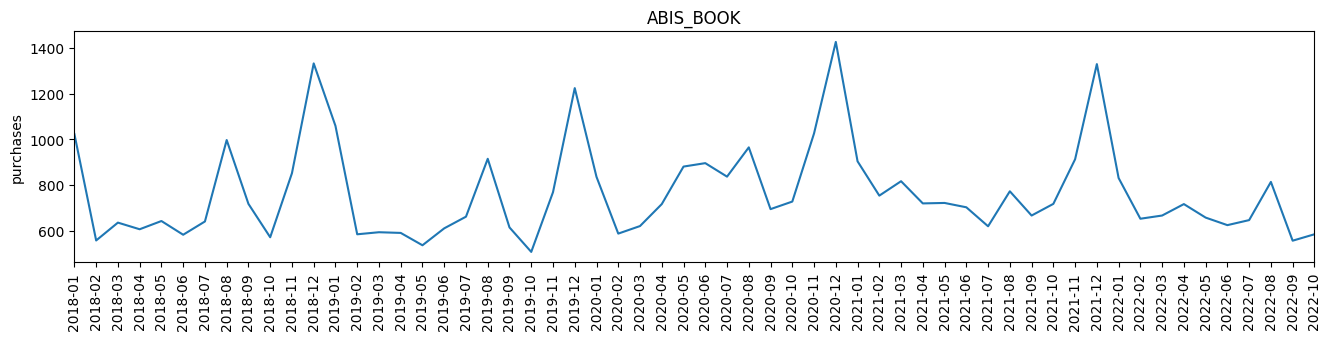

In [19]:
category = 'ABIS_BOOK'
fig,ax = plt.subplots(figsize=(16,3))
ax.plot(category_frequency_df[category])
ax.set_xlim('2018-01', '2022-10')
ax.set_ylabel('purchases')
ax.set_title(category)
_ = plt.xticks(rotation = 90)

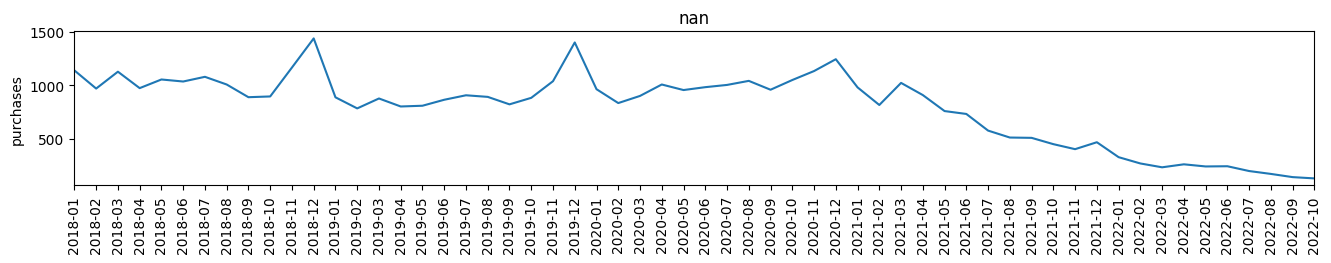

In [20]:
"""
Watch out for NaN...
"""
category = np.nan
fig,ax = plt.subplots(figsize=(16,2))
ax.plot(category_frequency_df[category])
ax.set_xlim('2018-01', '2022-10')
ax.set_ylabel('purchases')
ax.set_title(category)
_ = plt.xticks(rotation = 90)

There are lots of categories. Need some way to separate them. Like subcategories...

In [21]:
# Need to categorize / separate the items
print(list(filtered_categories.keys()))

['ABIS_BOOK', nan, 'TOYS_AND_GAMES', 'SOCKS', 'SHIRT', 'SKIN_CLEANING_AGENT', 'HEALTH_PERSONAL_CARE', 'PET_FOOD', 'GIFT_CARD', 'HEADPHONES', 'PANTS', 'UNDERPANTS', 'SNACK_FOOD_BAR', 'SHOES', 'MEDICATION', 'CELLULAR_PHONE_CASE', 'HOME', 'NUTRITIONAL_SUPPLEMENT', 'CLEANING_AGENT', 'TEA', 'SKIN_MOISTURIZER', 'BEAUTY', 'TOY_FIGURE', 'TABLETOP_GAME', 'SCREEN_PROTECTOR', 'WRITING_INSTRUMENT', 'PORTABLE_ELECTRONIC_DEVICE_COVER', 'HERBAL_SUPPLEMENT', 'SPORTING_GOODS', 'GROCERY', 'KITCHEN', 'COFFEE', 'VITAMIN', 'DRESS', 'PET_SUPPLIES', 'TOILET_PAPER', 'BATTERY', 'ELECTRONIC_CABLE', 'CHARGING_ADAPTER', 'PHYSICAL_VIDEO_GAME_SOFTWARE', 'DRINKING_CUP']


In [22]:
cat_electronics = [
    'CELLULAR_PHONE_CASE', 'HEADPHONES', 'SCREEN_PROTECTOR', 'PORTABLE_ELECTRONIC_DEVICE_COVER', 
    'BATTERY', 'ELECTRONIC_CABLE', 'CHARGING_ADAPTER', 'PHYSICAL_VIDEO_GAME_SOFTWARE'
]
cat_apparel = ['SOCKS', 'SHIRT', 'PANTS', 'UNDERPANTS', 'SHOES','DRESS']
cat_eat_drink = [
    'SNACK_FOOD_BAR', 'NUTRITIONAL_SUPPLEMENT', 'TEA',
    'HERBAL_SUPPLEMENT', 'GROCERY', 'COFFEE', 'VITAMIN'
]
cat_health_beauty = [
    'SKIN_MOISTURIZER', 'BEAUTY','MEDICATION', 'HEALTH_PERSONAL_CARE'
]
cat_cleaning = ['SKIN_CLEANING_AGENT', 'CLEANING_AGENT']
cat_toys = ['TOY_FIGURE', 'TABLETOP_GAME','TOYS_AND_GAMES']
cat_misc = [c for c in filtered_categories.keys() if ((c not in ['ABIS_BOOK', np.nan] + cat_electronics + cat_apparel + cat_eat_drink + cat_health_beauty + cat_toys))]
subcategories = {
    'Electronics': cat_electronics,
    'Apparel': cat_apparel,
    'Eat/Drink': cat_eat_drink,
    'Health/Beauty': cat_health_beauty,
    'Cleaning': cat_cleaning,
    'Toys/Games': cat_toys,
    'misc': cat_misc
}

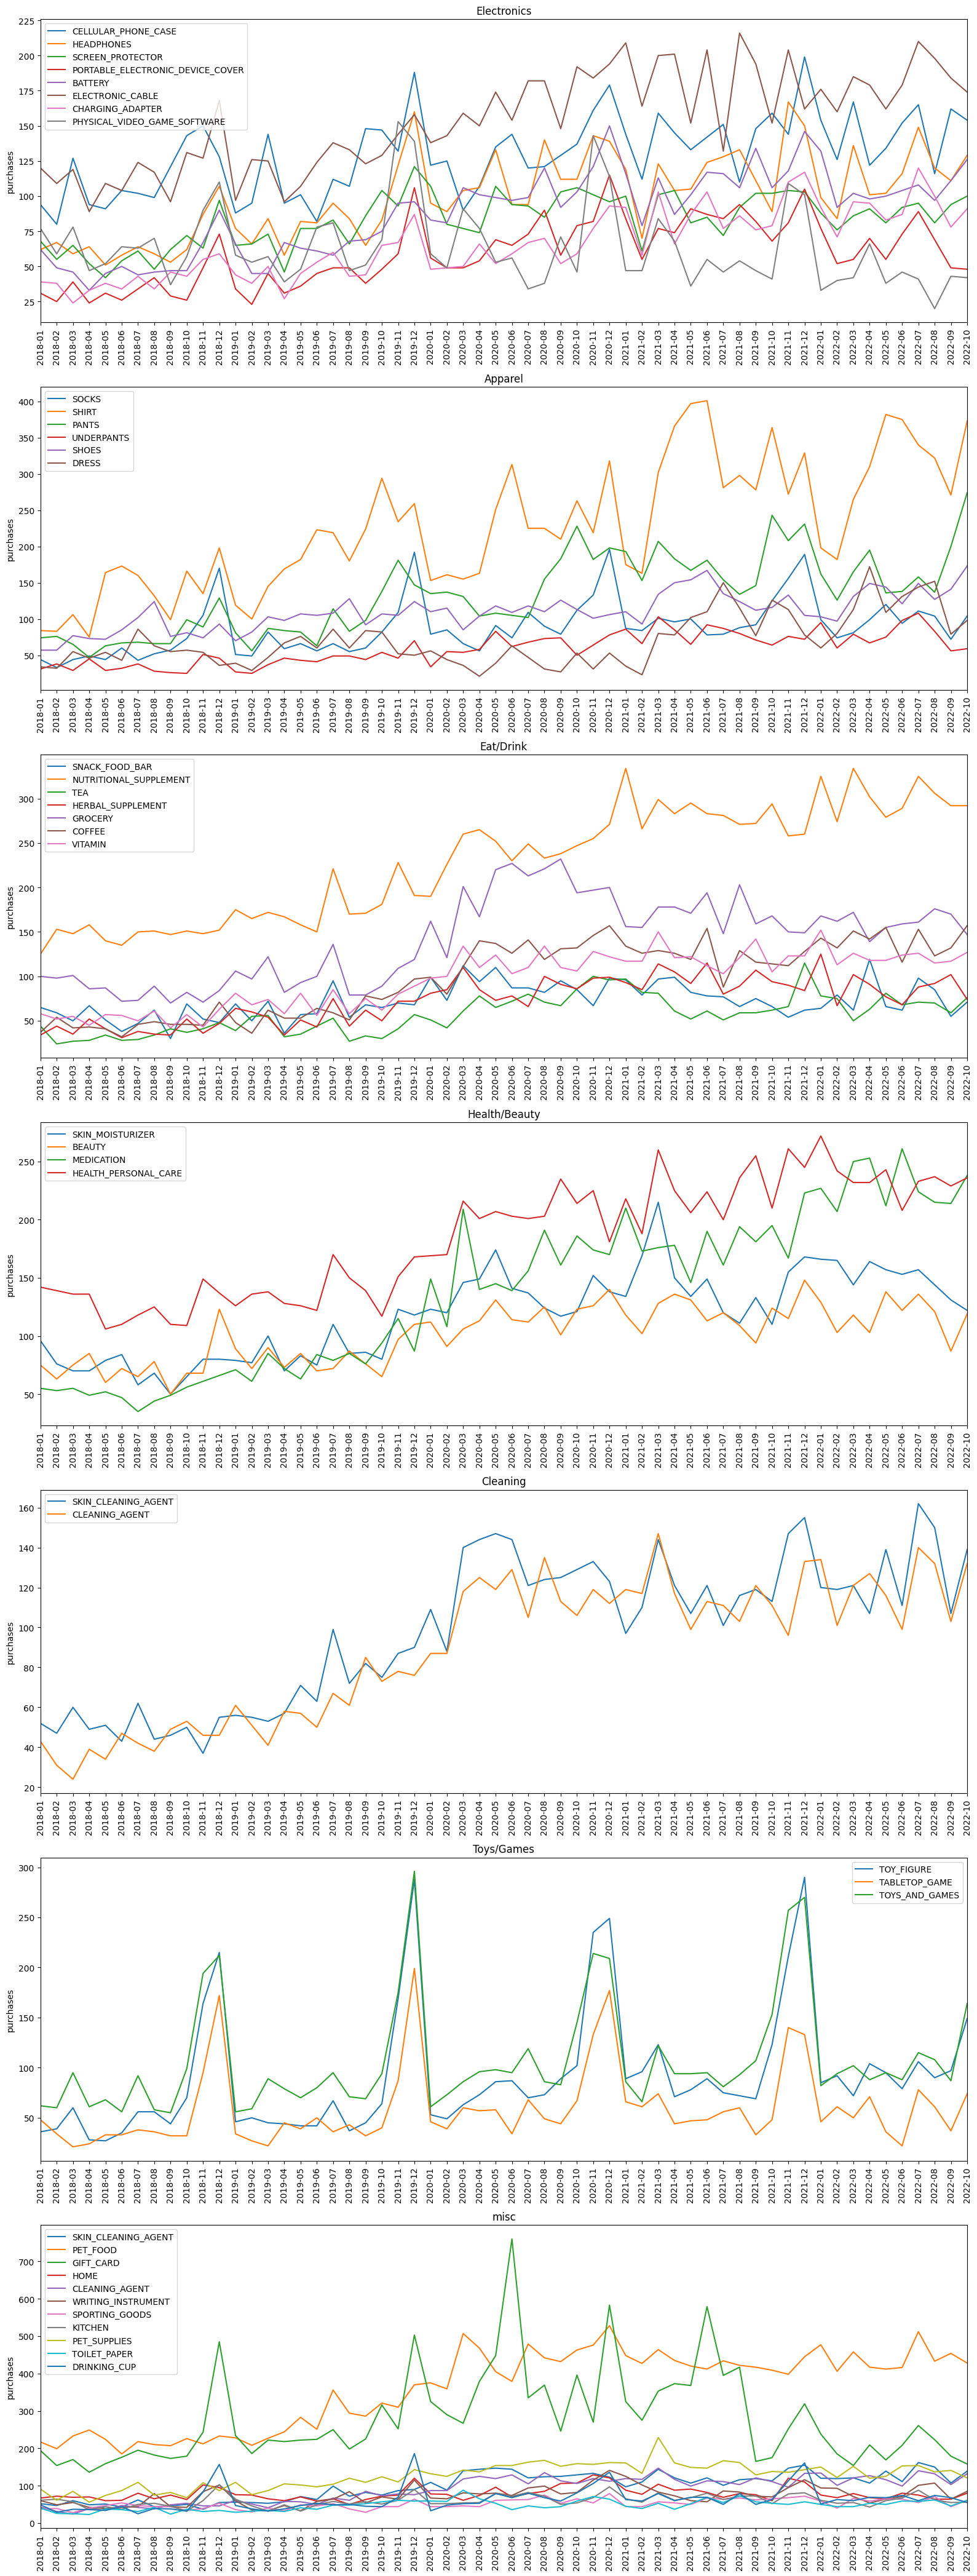

In [23]:
fig,axes = plt.subplots(len(subcategories), 1, figsize=(16,len(subcategories)*6))

for i, (subcategies_name, cats) in enumerate(subcategories.items()):
    ax = axes[i]
    for c, category in enumerate(cats): 
        ax.plot(category_frequency_df[category], label=category)
    ax.set_title(subcategies_name)
    ax.set_xlim('2018-01', '2022-10')
    ax.set_ylabel('purchases')
    [tick.set_rotation(90) for tick in ax.get_xticklabels()]

    ax.legend()
plt.tight_layout()

## Prices

In [24]:
category_price_median_df.head()

,ABIS_BOOK,NaN,TOYS_AND_GAMES,SOCKS,SHIRT,SKIN_CLEANING_AGENT,HEALTH_PERSONAL_CARE,PET_FOOD,GIFT_CARD,HEADPHONES,...,COFFEE,VITAMIN,DRESS,PET_SUPPLIES,TOILET_PAPER,BATTERY,ELECTRONIC_CABLE,CHARGING_ADAPTER,PHYSICAL_VIDEO_GAME_SOFTWARE,DRINKING_CUP
yyyy-mm,,,,,,,,,,,,,,,,,,,,,
2018-01,11.99,13.90,12.990,10.745,15.935,6.990,10.990,12.39,25.00,19.990,...,19.000,14.01,17.485,14.89,17.520,8.99,8.445,13.99,32.970,13.99
2018-02,10.57,13.96,12.485,11.990,14.990,8.940,11.600,12.59,20.00,16.990,...,14.925,11.70,15.990,16.58,14.105,8.99,7.990,17.09,29.990,13.00
2018-03,9.95,14.50,12.990,12.795,15.990,10.585,12.440,13.20,19.99,17.950,...,17.635,15.99,13.990,12.99,16.970,6.99,8.790,12.42,32.015,12.99
2018-04,10.40,14.99,12.350,11.880,14.990,11.000,11.985,13.20,25.00,16.055,...,15.870,14.24,19.990,12.97,21.990,8.99,8.990,11.99,39.990,14.99
2018-05,11.01,14.95,10.995,13.990,15.990,12.990,12.090,13.32,25.00,17.990,...,17.990,12.33,25.990,12.99,20.195,11.99,8.990,13.02,32.965,14.99


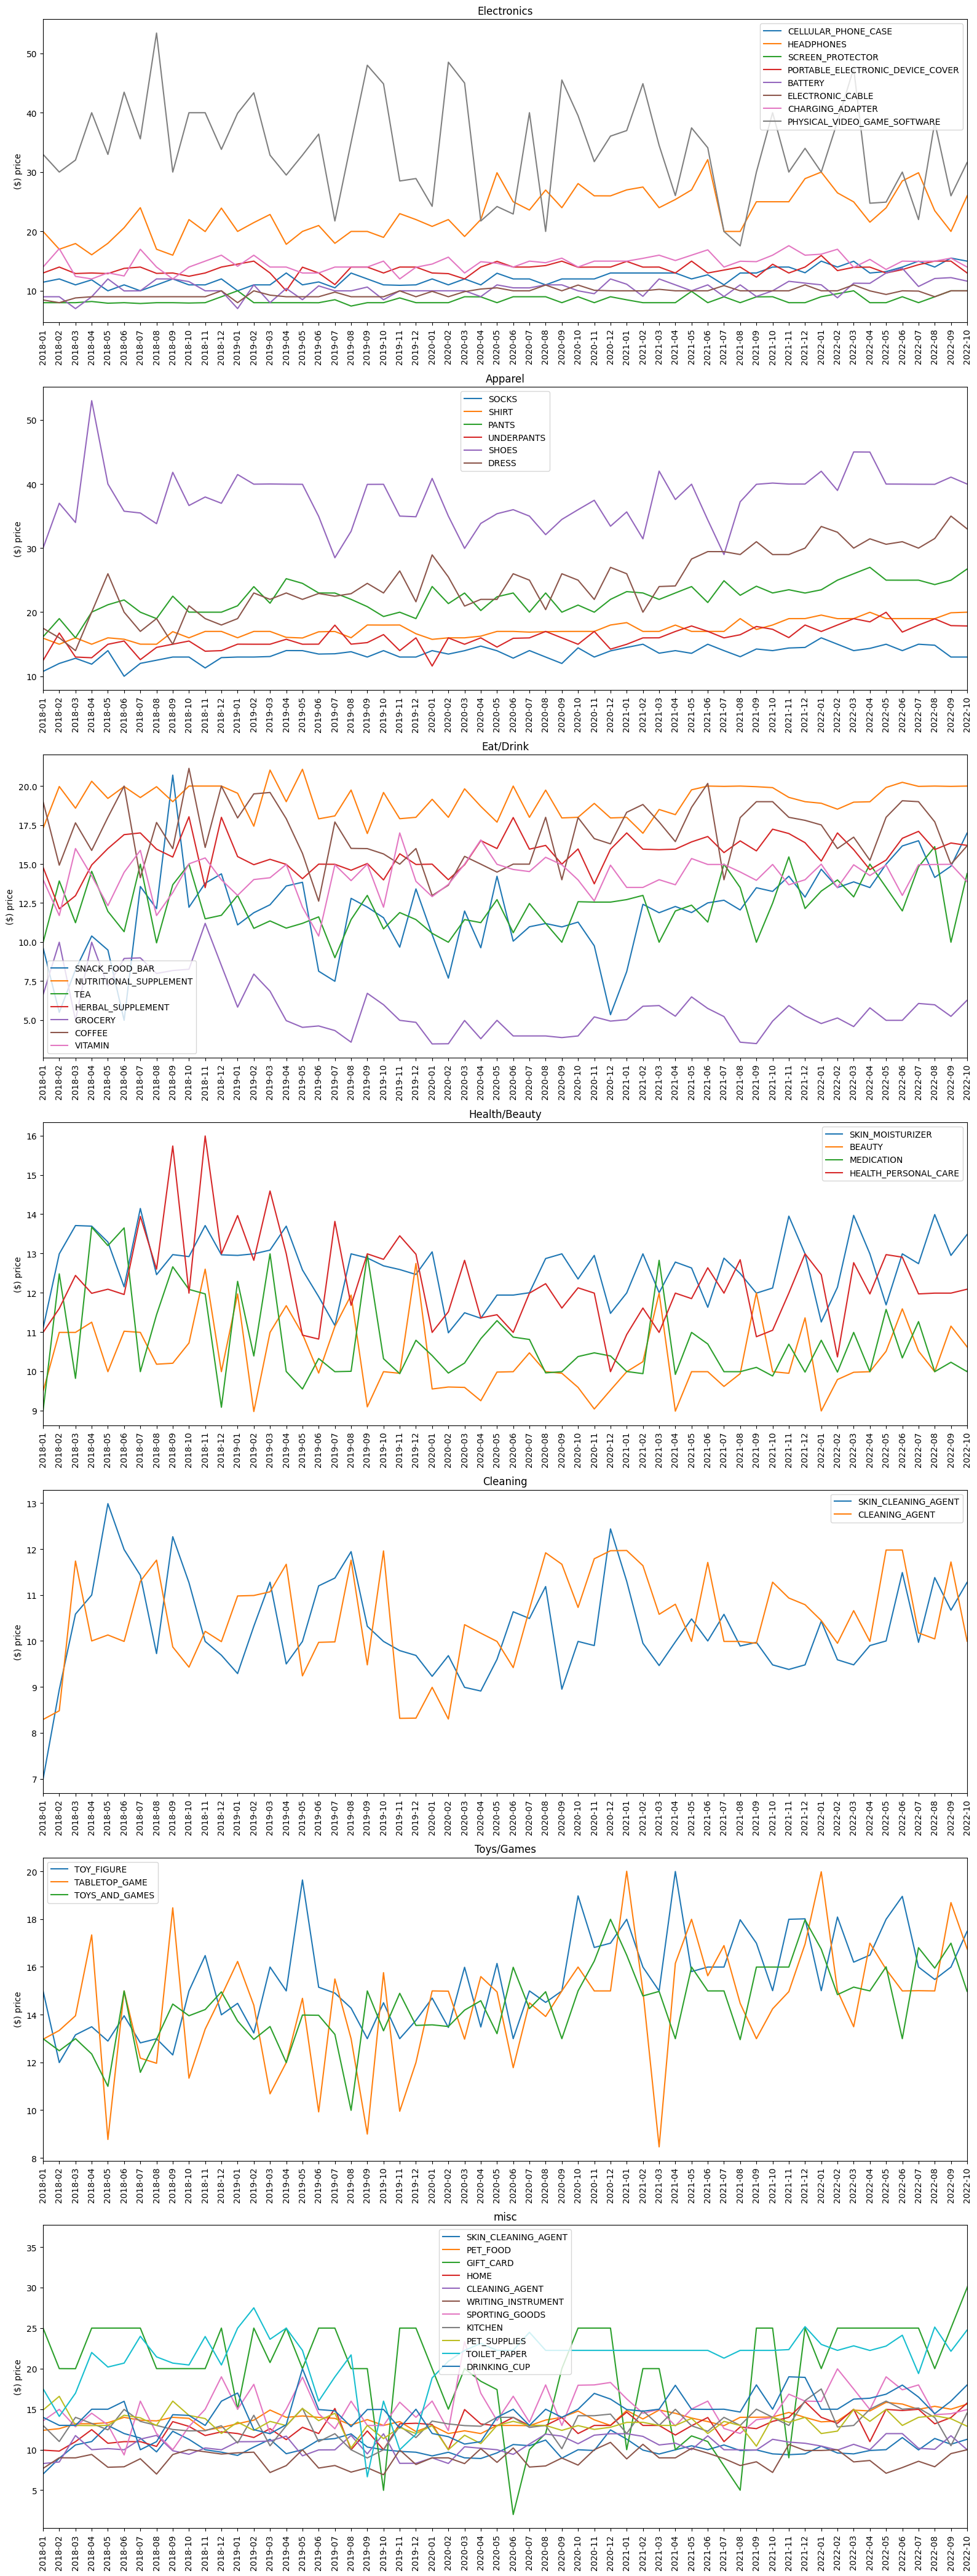

In [25]:
fig,axes = plt.subplots(len(subcategories), 1, figsize=(16,len(subcategories)*6))

for i, (subcategies_name, cats) in enumerate(subcategories.items()):
    ax = axes[i]
    for c, category in enumerate(cats): 
        ax.plot(category_price_median_df[category], label=category)
    ax.set_title(subcategies_name)
    ax.set_xlim('2018-01', '2022-10')
    ax.set_ylabel('($) price')
    [tick.set_rotation(90) for tick in ax.get_xticklabels()]

    ax.legend()
plt.tight_layout()

In [26]:
category_price_10p_df.head()

,ABIS_BOOK,NaN,TOYS_AND_GAMES,SOCKS,SHIRT,SKIN_CLEANING_AGENT,HEALTH_PERSONAL_CARE,PET_FOOD,GIFT_CARD,HEADPHONES,...,COFFEE,VITAMIN,DRESS,PET_SUPPLIES,TOILET_PAPER,BATTERY,ELECTRONIC_CABLE,CHARGING_ADAPTER,PHYSICAL_VIDEO_GAME_SOFTWARE,DRINKING_CUP
yyyy-mm,,,,,,,,,,,,,,,,,,,,,
2018-01,4.856,4.988,6.212,7.936,8.286,3.610,4.963,4.990,3.000,5.378,...,5.986,6.679,4.269,5.940,6.948,4.292,5.781,6.780,14.292,4.932
2018-02,4.665,5.990,5.920,7.798,8.182,2.686,5.326,5.990,3.000,6.140,...,5.990,5.731,5.375,3.740,5.980,4.910,5.290,8.684,11.640,6.362
2018-03,3.920,5.648,4.990,8.704,8.990,4.303,5.140,4.974,2.870,4.880,...,5.264,7.974,8.154,4.990,6.252,3.645,5.982,7.221,9.858,6.110
2018-04,4.202,6.606,5.990,7.790,7.498,5.650,5.560,4.778,3.000,8.017,...,3.620,8.550,7.745,5.265,6.198,4.330,5.698,7.906,18.190,6.640
2018-05,4.200,6.520,5.767,7.009,9.990,4.790,5.935,4.955,1.392,8.610,...,5.720,7.982,12.850,5.413,6.990,5.712,5.372,7.990,16.632,7.279


In [171]:
filtered_total_purchases_df

,category,total purchases
1,NaN,46208
0,ABIS_BOOK,45563
7,PET_FOOD,21389
8,GIFT_CARD,16359
4,SHIRT,13642
17,NUTRITIONAL_SUPPLEMENT,13580
6,HEALTH_PERSONAL_CARE,10992
37,ELECTRONIC_CABLE,9113
29,GROCERY,8366
14,MEDICATION,8277
